## Ungraded Lab: Effect of Compacted Images in Training 

Here we will go through how changing the target size of the generator images will affect the architecture and performance of our model. 

In [1]:
import os 

# Directory with training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./validation-horse-or-human/horses')

# Directory with validation horse pictures
validation_human_dir = os.path.join('./validation-horse-or-human/humans')

We can check that the directories are not empty and that the train set has more images than the validation set

In [3]:
train_horse_names  = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names  = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_names  = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_names[:10]}')

validation_human_names  = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')


TRAIN SET HORSES: ['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']
TRAIN SET HUMANS: ['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png']
VAL SET HORSES: ['horse1-000.png', 'horse1-105.png', 'horse1-122.png', 'horse1-127.png', 'horse1-170.png', 'horse1-204.png', 'horse1-224.png', 'horse1-241.png', 'horse1-264.png', 'horse1-276.png']
VAL SET HUMANS: ['valhuman01-00.png', 'valhuman01-01.png', 'valhuman01-02.png', 'valhuman01-03.png', 'valhuman01-04.png', 'valhuman01-05.png', 'valhuman01-06.png', 'valhuman01-07.png', 'valhuman01-08.png', 'valhuman01-09.png']


In [4]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


#### Build the Model

The model will follow the same architecture as earlier models, but the KEY difference is in the **INPUT_SHAPE** parameter of the first Conv2D layer. 

Since we will be compacting the images later in the generator we need to specify the expected image size here. So instead of 300x300 we specify a smaller 150x150 array

In [5]:
import tensorflow as tf 

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    # This is the second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # This is the third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # ... We can put more conv. layers if we want to see the effect! 

    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

We can see the difference from earlier models when we print __model.summary()__

As expected there will be less inputs to the _Dense_ layer at the end of the model compared to the previous labs. This is since we used the same number of max pooling layers in our model. And since we have a smaller image to begin with (150x150) the output after all the pooling layers will also be smaller! 

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

We'll be using the same settings for training: 

In [7]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy', 
                optimizer=RMSprop(learning_rate=0.001), 
                metrics=['accuracy'])
                

#### Data Preprocessing 

Now we will instantiate the data generators. We will be compacting the image by specifying the _target_size_ parameter. 

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    './horse-or-human/',
    target_size=(150,150), 
    batch_size=128,
    class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator 
validation_generator = validation_datagen.flow_from_directory(
    './validation-horse-or-human/',
    target_size=(150, 150),
    batch_size=32, 
    class_mode='binary'
)


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


#### Training 

Note our observations about how fast the model trains and the accuracies we're getting in the training and validation sets 

In [9]:
history = model.fit(
    train_generator, 
    steps_per_epoch = 8,
    epochs=15,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=8)
    

Epoch 1/15
8/8 [==============================] - 21s 2s/step - loss: 1.5251 - accuracy: 0.5506 - val_loss: 0.4516 - val_accuracy: 0.8828
Epoch 2/15
8/8 [==============================] - 19s 2s/step - loss: 0.5362 - accuracy: 0.7853 - val_loss: 0.4341 - val_accuracy: 0.8438
Epoch 3/15
8/8 [==============================] - 19s 2s/step - loss: 0.2676 - accuracy: 0.8932 - val_loss: 0.9737 - val_accuracy: 0.7617
Epoch 4/15
8/8 [==============================] - 19s 2s/step - loss: 0.1667 - accuracy: 0.9444 - val_loss: 0.8284 - val_accuracy: 0.8281
Epoch 5/15
8/8 [==============================] - 20s 3s/step - loss: 0.0896 - accuracy: 0.9688 - val_loss: 1.0827 - val_accuracy: 0.8438
Epoch 6/15
8/8 [==============================] - 19s 2s/step - loss: 0.2009 - accuracy: 0.9321 - val_loss: 2.6802 - val_accuracy: 0.6758
Epoch 7/15
8/8 [==============================] - 19s 2s/step - loss: 0.1525 - accuracy: 0.9377 - val_loss: 0.7734 - val_accuracy: 0.8203
Epoch 8/15
8/8 [==================

#### Model Prediction 

It is good practice to try running the model over some handpicked images. 


In [18]:
import numpy as np 
from tensorflow.keras.utils import load_img, img_to_array
import os 

images = os.listdir("./images/")

print(images)

for i in images: 
    print()
    # predicting images 
    path = "./images/" + i 
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x /= 255 
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images ,batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(i + " is a human")
    else: 
        print(i + " is a horse")
        

['bb.jpg', 'me.jpg', 'IMG_1237.jpg', 'IMG_1237[627].png']

1/1 [==============================] - 0s 27ms/step
[0.41867]
bb.jpg is a horse

1/1 [==============================] - 0s 23ms/step
[0.00097694]
me.jpg is a horse

1/1 [==============================] - 0s 24ms/step
[2.3236775e-05]
IMG_1237.jpg is a horse

1/1 [==============================] - 0s 24ms/step
[4.5115775e-07]
IMG_1237[627].png is a horse


#### Visualizing Intermediate Representations 

Notice that the output at the last convolution layer is even more abstract because it contains fewer pixels!

1/1 [==============================] - 0s 78ms/step


C:\Users\Bruger\AppData\Local\Temp\ipykernel_44796\4123242844.py:44: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


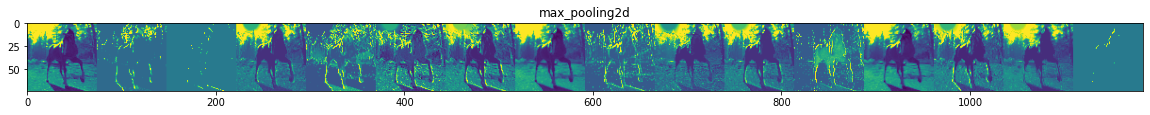

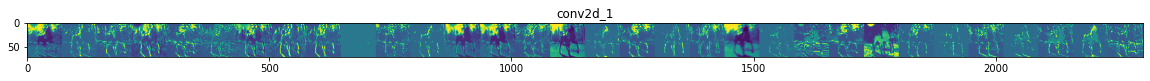

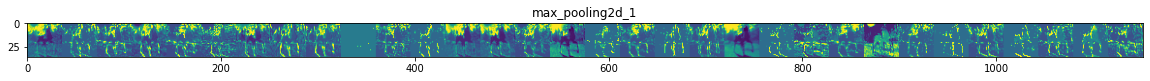

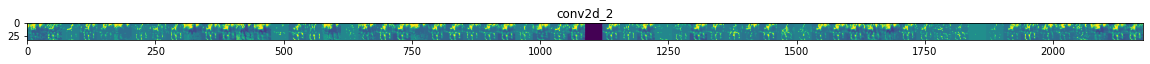

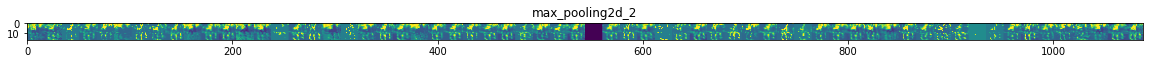

In [19]:
%matplotlib inline 

import matplotlib.pyplot as plt 
import random 
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input and will output
# intermediate representations for all layers in the previous models after the first 
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
img = load_img(img_path, target_size=(150,150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Scale by 1/255 
x /=255

# Run the image through the network thus obtaining all intermediate representations for this image 
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers so we can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations 
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

        # Just do this for the conv/maxpool layers not the fully-connected layers 
        n_features = feature_map.shape[-1]

        # The feature map has a shape (1, size, size, n_features)
        size = feature_map.shape[1]

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x 
        
        # Display the grid 
        scale = 20. / n_features 
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')